In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer
import torch
from torch.utils.data import DataLoader, Dataset


In [2]:
mdata =  pd.read_csv("/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv")

In [3]:
mdata.head(100)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
95,Daniel Day-Lewis is the most versatile actor a...,positive
96,My guess would be this was originally going to...,negative
97,"Well, I like to watch bad horror B-Movies, cau...",negative
98,"This IS the worst movie I have ever seen, as w...",negative


In [4]:
mdata.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


In [5]:
mdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [6]:
train_data, test_data = train_test_split(mdata, test_size=0.2, random_state=42, stratify=mdata['sentiment'])

# Display the shapes of the splits
print("Training data shape:", train_data.shape)
print("Testing data shape:", test_data.shape)


Training data shape: (40000, 2)
Testing data shape: (10000, 2)


In [7]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [8]:
# Define a Dataset class
class IMDBDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = 1 if self.labels[idx] == 'positive' else 0

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }


In [9]:
MAX_LENGTH = 256
train_dataset = IMDBDataset(train_data['review'].values, train_data['sentiment'].values, tokenizer, MAX_LENGTH)
test_dataset = IMDBDataset(test_data['review'].values, test_data['sentiment'].values, tokenizer, MAX_LENGTH)

In [10]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [11]:
from transformers import BertForSequenceClassification, AdamW

# Load the BERT model for sequence classification
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# Set the device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define optimizer
optimizer = AdamW(model.parameters(), lr=2e-5)


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [12]:
from tqdm import tqdm

# Training function
def train_model(model, train_loader, optimizer, device, epochs=20):
    model.train()
    for epoch in range(epochs):
        loop = tqdm(train_loader, leave=True)
        for batch in loop:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            loss.backward()
            optimizer.step()

            loop.set_description(f'Epoch {epoch + 1}')
            loop.set_postfix(loss=loss.item())

# Train the model
train_model(model, train_loader, optimizer, device)


Epoch 20: 100%|██████████| 2500/2500 [21:58<00:00,  1.90it/s, loss=0.00268]


In [13]:
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

In [14]:
def evaluate_model(model, test_loader, device):
    model.eval()
    predictions = []
    true_labels = []

    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits

            preds = torch.argmax(logits, dim=1).cpu().numpy()
            predictions.extend(preds)
            true_labels.extend(labels.cpu().numpy())

    return np.array(predictions), np.array(true_labels)

In [15]:
# Get predictions and true labels
predictions, true_labels = evaluate_model(model, test_loader, device)


In [16]:
# Calculate accuracy and F1 score
accuracy = accuracy_score(true_labels, predictions)
f1 = f1_score(true_labels, predictions)


In [17]:
print(f'Accuracy: {accuracy:.4f}')
print(f'F1 Score: {f1:.4f}')

Accuracy: 0.9220
F1 Score: 0.9234


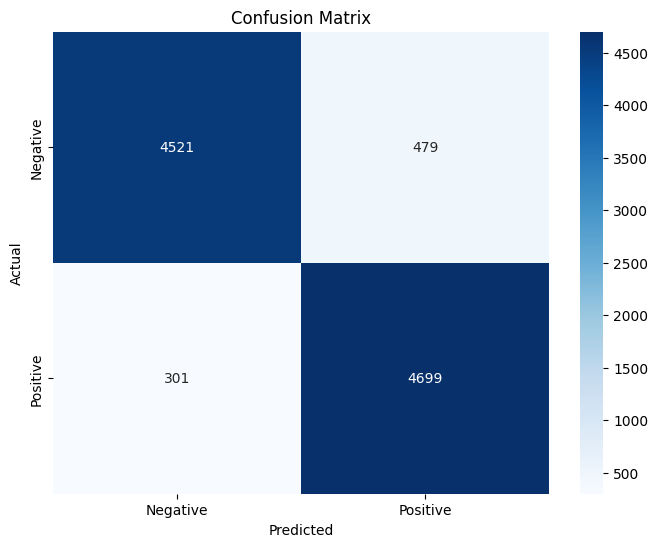

In [18]:
# Confusion Matrix
conf_matrix = confusion_matrix(true_labels, predictions)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

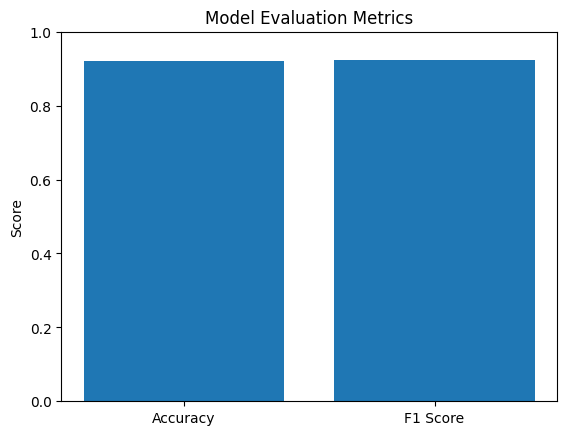

In [19]:
# Plot Accuracy and F1 Score
metrics = {'Accuracy': accuracy, 'F1 Score': f1}
plt.bar(metrics.keys(), metrics.values())
plt.ylim(0, 1)
plt.ylabel('Score')
plt.title('Model Evaluation Metrics')
plt.show()


In [20]:
# Generate classification report
class_report = classification_report(true_labels, predictions, target_names=['Negative', 'Positive'])
print(class_report)

              precision    recall  f1-score   support

    Negative       0.94      0.90      0.92      5000
    Positive       0.91      0.94      0.92      5000

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



In [21]:
# At # epochs =3
#               precision    recall  f1-score   support

#     Negative       0.96      0.89      0.92      5000
#     Positive       0.90      0.96      0.93      5000

#     accuracy                           0.93     10000
#    macro avg       0.93      0.93      0.93     10000
# weighted avg       0.93      0.93      0.93     10000